# Project - Term Deposit
**Name: Zimin Lee**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.utils import shuffle

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

#from sklearn.model_selection import HalvingGridSearchCV

**Background**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

In [2]:
#Read File 
df = pd.read_csv("C:\\Users\\zzzim\\Desktop\\Apziva\\term-deposit-marketing-2020.csv", sep=',')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,no


In [3]:
df.info

<bound method DataFrame.info of        age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  da

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

**Variables**

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

<AxesSubplot:>

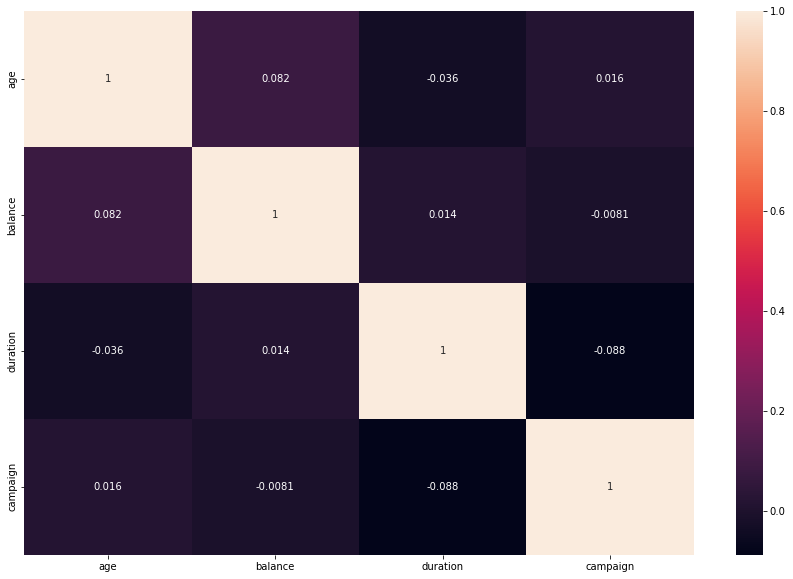

In [5]:
#Correlation Matrix: include numeric, exclude categorical
df_num = df[['age', 'balance', 'duration', 'campaign']]

plt.figure(figsize=(15, 10))
sns.heatmap(df_num.corr(), annot=True)

None of the variables/features are correlated. Thus, all variables will be include to build a classifier.

In [6]:
#Check for imbalance data
df[['y']].value_counts()

y  
no     37104
yes     2896
dtype: int64

There is a massive imbalance of subsbribe (yes/no) where data with "no" is signifigantly higher than 'yes'. Of 40000 observations from the dataset, 92% are subscribe "no". This will be dealt by downsampling the dataset to the size of subscribe 'yes' counts.

## Predicting if the customer will subscribe (yes/no) to a term deposit (variable y) with Classfier

### Data Preparation

In [8]:
rs = 0 #assign random seed

#Seperate features and label
X = df[['age','job','marital','education','default', 'balance', 'housing','loan', 'contact', 'day', 'month', 'duration', 'campaign']]
y = df[['y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = rs)

#Downsampling No class. Sampling only 5000 no class from training set and keep all yes class
no = y_train[y_train['y']=='no']
yes_Y  = y_train[y_train['y']=='yes']
yes_X = X_train[X_train.index.isin(yes_Y.index)]

#Sampling only 6000 no class from training set
no_Y = no.sample(6000)

no_Y_id = no_Y.index.tolist()
duplicate = set([x for x in no_Y_id if no_Y_id.count(x) > 1])
no_Y = no_Y.drop(index= duplicate)
no_X = X_train[X_train.index.isin(no_Y.index)]

no_Y_id = no_Y.index.tolist()
no_Y = no_Y.sort_index()
#no_X = no_X.sort_index()

X_train = pd.concat([yes_X, no_X])
y_train = pd.concat([yes_Y, no_Y])


#Save column names
X_col = X_train.columns

#OHE
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train)
X_train = ohe.transform(X_train).toarray()
X_test= ohe.transform(X_test).toarray()
ohe_df = pd.DataFrame(X_train, columns=ohe.get_feature_names(X.columns))

### Decision Tree

In [9]:
# simple decision tree training
clf = DecisionTreeClassifier(random_state=rs)

clf.fit(X_train, y_train)
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.8731666666666666


In [10]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.95      0.92      0.93     11131
         yes       0.23      0.33      0.27       869

    accuracy                           0.87     12000
   macro avg       0.59      0.62      0.60     12000
weighted avg       0.89      0.87      0.88     12000



In [11]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 10),
          'min_samples_leaf': range(0, 20, 1)[1:]}

cv_1 = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)
cv_1.fit(X_train, y_train)

result_set = cv_1.cv_results_
print(cv_1.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1}


In [12]:
clf_grid = DecisionTreeClassifier(criterion = 'gini', max_depth = 9 , min_samples_leaf=9)
clf_grid.fit(X_train, y_train)
print("Train accuracy:", clf_grid.score(X_train, y_train))
print("Test accuracy:", clf_grid.score(X_test, y_test))

Train accuracy: 0.7917030023670113
Test accuracy: 0.9093333333333333


In [13]:
y_pred = clf_grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.94      0.96      0.95     11131
         yes       0.33      0.25      0.29       869

    accuracy                           0.91     12000
   macro avg       0.64      0.61      0.62     12000
weighted avg       0.90      0.91      0.90     12000



The decision tree classifier did not perform well and did not handle data imbalance well. This is evident from the accuracy of predicting a customer will accept a loan being much lower than not accepting one.This classifier managed to hit the 90% overall accuracy withe the optimal parameter, but further classfication method will be considered to improve the ability to predict customers that will accept a term deposit.

### XGBoost

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
y_test = le.fit_transform(y_test.values.ravel())

In [15]:
#XGBoost
xgb_model = xgb.XGBClassifier(random_state=rs)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
print("Train accuracy:", xgb_model.score(X_train, y_train))
print("Test accuracy:", xgb_model.score(X_test, y_test))

Train accuracy: 0.8055313317553258
Test accuracy: 0.9224166666666667


In [16]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11131
           1       0.43      0.21      0.28       869

    accuracy                           0.92     12000
   macro avg       0.68      0.59      0.62     12000
weighted avg       0.90      0.92      0.91     12000



The XGBoost classifier manage to improve the overall performance by only 1%. However, it has signifigantly improve the predicting ability of customer accepting a term deposit.XGBoost will not be selected as the best performing model as the predicting ability for customer that accept a loan is still very low. Further classification method will be considered to improve the predicting accuracy for yes class.

### SVM

In [17]:
svm = SVC(C=1, kernel='linear')
svm.fit(X_train, y_train.ravel())

# training and test accuracy
print("Train accuracy:", svm.score(X_train, y_train))
print("Test accuracy:", svm.score(X_test, y_test))

Train accuracy: 0.9556496823221627
Test accuracy: 0.8970833333333333


In [19]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     11131
           1       0.37      0.58      0.45       869

    accuracy                           0.90     12000
   macro avg       0.67      0.75      0.70     12000
weighted avg       0.92      0.90      0.91     12000



In [22]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
 ]

svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, y_train.ravel())
grid_search.cv_results_

{'mean_fit_time': array([47.2024848 , 44.78578053, 42.51954103, 44.19169054, 44.22329478,
        58.84599743, 48.3535974 , 42.94331136, 38.70213127, 63.82246385,
        48.55381184, 47.20967007, 41.77689443, 74.79897876, 48.94060326,
        47.40635691, 46.50575428, 74.94030218, 69.28568106, 47.16734972,
        47.57178617, 75.3571702 , 67.36452336, 43.89131594, 47.29673228]),
 'std_fit_time': array([0.52622624, 0.35149274, 0.58045724, 0.7645463 , 1.59818101,
        0.43286189, 1.25430862, 1.65172489, 0.3305201 , 0.2026914 ,
        0.39468877, 0.76933772, 0.15681914, 0.24678543, 0.28693495,
        0.41975766, 0.19130207, 0.24194244, 7.52834883, 0.23095774,
        0.62712383, 0.86724396, 7.64271067, 0.42450775, 0.37261638]),
 'mean_score_time': array([10.49486594,  9.38253226,  7.02684517,  5.94456897,  5.74505539,
        33.64780011, 26.31232114, 25.70337615, 21.91705427, 35.42796154,
        26.30730019, 25.29206395, 23.13554387, 38.15984001, 26.89472308,
        25.41323972,

In [23]:
best_svm = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_svm]
print(params)

{'C': 1, 'kernel': 'linear'}


In [24]:
svm_best = SVC().set_params(**params)
svm_best.fit(X_train, y_train.ravel())

# training and test accuracy
print("Train accuracy:", svm_best.score(X_train, y_train))
print("Test accuracy:", svm_best.score(X_test, y_test))

Train accuracy: 0.9556496823221627
Test accuracy: 0.8970833333333333


In [25]:
y_pred = svm_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     11131
           1       0.37      0.58      0.45       869

    accuracy                           0.90     12000
   macro avg       0.67      0.75      0.70     12000
weighted avg       0.92      0.90      0.91     12000



In [26]:
scores = cross_val_score(svm_best, X_test, y_test, cv=5)
avg_score = np.mean(scores)

print("5-fold cross validation score:", scores)
print("5-fold cross validation average performance score:", avg_score)

5-fold cross validation score: [0.92958333 0.92666667 0.92       0.925      0.92166667]
5-fold cross validation average performance score: 0.9245833333333333


The SVM classifier has the best accuracy and the SVM model with optimal hyperparameter {'C': 1, 'kernel': 'linear'} obtained through grid search has a overall accuracy of 89.7%. Additionally the ability to predict a person accepting a term deposit is 37% which is the lower than the XGBoost classifier. 


### Best Model 

The best classifier in this project is XGBoost classifier with an overall accuracy of  92% and 43% accuracy on prediction customer that will accept a term deposit. 

In [27]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11131
           1       0.43      0.21      0.28       869

    accuracy                           0.92     12000
   macro avg       0.68      0.59      0.62     12000
weighted avg       0.90      0.92      0.91     12000



Given 12000 samples with a customer that accepts term deposit, this XGBoost model managed to classify 373 (43%) of the samples correctly. Whereas for the 11131 of the customer that did not accept a term deposit, 10463(94%) have been classified correctly. The ability to correctly classified a customer that will acceprt term deposit can be improve by increase the number of training samples.

#### 5-fold cross validation

In [28]:
scores = cross_val_score(xgb_model, X_test, y_test, cv=5)
avg_score = np.mean(scores)

print("5-fold cross validation score:", scores)
print("5-fold cross validation average performance score:", avg_score)

5-fold cross validation score: [0.93083333 0.93       0.92583333 0.92583333 0.9275    ]
5-fold cross validation average performance score: 0.9279999999999999


The 5-fold cross validation average performance score for the XGBoost classifier is 92.8% which has met the success criteria. 

### Feature Importance

The XGBoost model which has the highest precision of customers accepting a term deposit will be used to extract the importance the features. 

In [29]:
# get feature importances
feature_importances = zip(X_col, xgb_model.feature_importances_)

sorted_feature = []
for i in list(feature_importances):
    sorted_feature.append(i)

sorted_feature.sort(key = lambda row: row[1], reverse=True)
for i in sorted_feature:
    print (i)

('housing', 0.005235288)
('loan', 0.0038257497)
('contact', 0.0036746704)
('month', 0.0030853902)
('default', 0.002623975)
('campaign', 0.0026060191)
('marital', 0.0021823612)
('day', 0.0009160614)
('age', 0.0)
('job', 0.0)
('education', 0.0)
('balance', 0.0)
('duration', 0.0)


Based on the feature importance of the XGboost classifier. It is suggested that housing, month and balance has the highest importance. Whereas age, job, maritial, education, balance and duration has no effect on predicting whether a customer will invest in term deposit. 